<a href="https://colab.research.google.com/github/Idan-Alter/OU-22961-Deep-Learning/blob/main/22961_7_3_conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

train_data_transformed = torchvision.datasets.FashionMNIST(
    root="/22961", train=True, download=True,
    transform=torchvision.transforms.ToTensor())

train_dataloader = DataLoader(
    train_data_transformed, batch_size=256)
img, _ = next(iter(train_dataloader))

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cuda:0


#Transposed Conv

In [ ]:
def conv_backward(dCdY, K):
  p, q   = K.size()
  Hy, Wy = dCdY.size()
  H = Hy+p-1
  W = Wy+q-1
  dCdX = torch.zeros((H,W))
  for r in range(Hy):
   for s in range(Wy):
    #forward: Y[r,s]  = (X[r:r+p,s:s+q]*K).sum()
    #backward:
    dCdX[r:r+p, s:s+q] += dCdY[r,s]*K
  return dCdX

In [ ]:
def transposed_conv(input, K):
  Cin, p, q = K.size()
  _, Hy, Wy = input.squeeze().size()
  H = Hy+p-1
  W = Wy+q-1
  output = torch.zeros((H,W))
  for c in range(Cin):
    output += conv_backward(input.squeeze()[c,...], K[c,...])
  return output

In [ ]:
A = nn.ConvTranspose2d(2,1,2, bias=False)
K = A.weight[:,0,...]
print(K.size())

torch.Size([2, 2, 2])


In [ ]:
input = torch.randn((1,2,3,3))
with torch.no_grad():
  print(A(input).squeeze())
  print(transposed_conv(input, K))

tensor([[-0.8040,  1.3045, -0.5247,  0.2762],
        [-1.4348,  1.6465, -2.0373,  0.4551],
        [-0.7032,  1.3117, -0.9884, -0.0761],
        [ 0.1021,  1.1662,  0.5507,  0.0803]])
tensor([[-0.8040,  1.3045, -0.5247,  0.2762],
        [-1.4348,  1.6465, -2.0373,  0.4551],
        [-0.7032,  1.3117, -0.9884, -0.0761],
        [ 0.1021,  1.1662,  0.5507,  0.0803]])


#Conv AE

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1   = nn.Conv2d(1, 32, 3, padding="same")
        self.conv2   = nn.Conv2d(32, 32, 3, padding="same")
        self.maxpool = nn.MaxPool2d(2) 
        self.relu    = nn.ReLU()
    def forward(self, image):
      temp = self.relu(self.conv1(image))
      temp = self.maxpool(temp)
      temp = self.relu(self.conv2(temp))
      feature_map = self.maxpool(temp)
      return feature_map

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1     = nn.ConvTranspose2d(32, 32, 7, stride=2)
        self.conv2     = nn.ConvTranspose2d(32, 1, 10)
        self.relu      = nn.ReLU()
        self.sigmoid   = nn.Sigmoid()
    def forward(self, feature_map):
      temp = self.relu(self.conv1(feature_map))
      reconstructed_image = self.sigmoid(self.conv2(temp))
      return reconstructed_image

In [ ]:
autoencoder = nn.Sequential(Encoder(),
                            Decoder()).to(device)
optimizer   = torch.optim.AdamW(autoencoder.parameters())
MSELoss     = nn.MSELoss()

In [ ]:
def iterate_batch(imgs):
  imgs = imgs.to(device)
  optimizer.zero_grad()
  reconstructed = autoencoder(imgs)
  loss = MSELoss(reconstructed, imgs)
  loss.backward()
  optimizer.step()
  return loss

In [ ]:
batches = len(train_dataloader)
epochs  = 5
batch_loss = torch.empty(batches, device=device)
epoch_loss = torch.empty(epochs, device=device)
for epoch_idx in tqdm(range(epochs)):
  for batch_idx, (imgs, _) in enumerate(train_dataloader):
    batch_loss[batch_idx] = iterate_batch(imgs)
  with torch.no_grad():
    epoch_loss[epoch_idx] = batch_loss.mean()

100%|██████████| 5/5 [00:51<00:00, 10.30s/it]


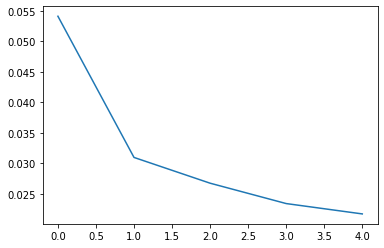

In [ ]:
plt.plot(epoch_loss[:epoch_idx+1].cpu().detach());

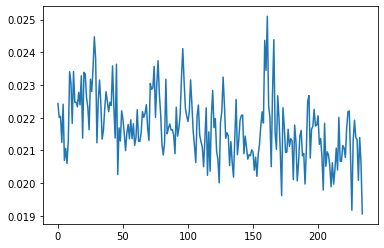

In [ ]:
plt.plot(batch_loss.cpu().detach());

In [ ]:
imgs, _ = next(iter(train_dataloader))

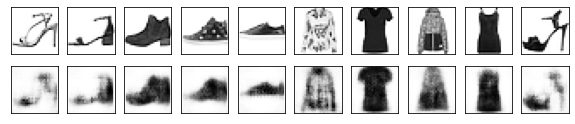

In [ ]:
num_images=10
with torch.no_grad():
  reconstructed = autoencoder(imgs.to(device)).cpu()
  fig,axes = plt.subplots(2, num_images, sharey=True)
  fig.set_figheight(2)
  fig.set_figwidth(10)
  rand_idx = torch.randint(size=(num_images,), high=imgs.size(0))
  for idx in range(num_images):
    axes[0,idx].imshow(imgs[rand_idx[idx],...].reshape(28,28).detach(), cmap='Greys')
    axes[0,idx].axes.get_xaxis().set_visible(False)
    axes[0,idx].axes.get_yaxis().set_visible(False)


    axes[1,idx].imshow(reconstructed[[rand_idx[idx]],...].reshape(28,28).detach(), cmap='Greys')
    axes[1,idx].axes.get_xaxis().set_visible(False)
    axes[1,idx].axes.get_yaxis().set_visible(False)

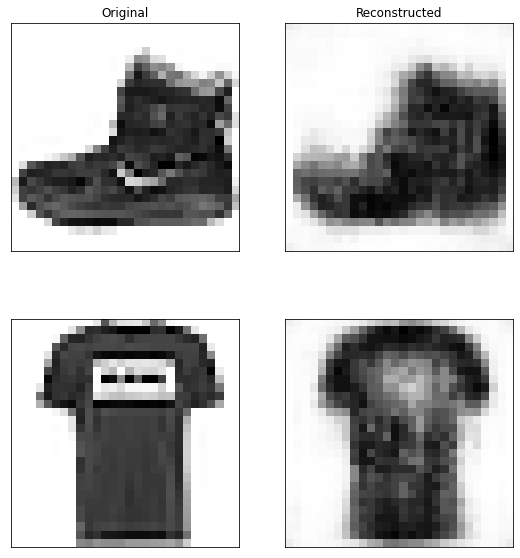

In [ ]:
num_images=2
with torch.no_grad():
  reconstructed = autoencoder(imgs.to(device)).cpu()
  fig,axes = plt.subplots(num_images, 2)
  fig.set_figheight(10)
  fig.set_figwidth(9)
  for idx in range(num_images):
    axes[idx,0].imshow(imgs[idx,...].reshape(28,28).detach(), cmap='Greys')
    axes[idx,0].axes.get_xaxis().set_visible(False)
    axes[idx,0].axes.get_yaxis().set_visible(False)
    

    axes[idx,1].imshow(reconstructed[idx,...].reshape(28,28).detach(), cmap='Greys')
    axes[idx,1].axes.get_xaxis().set_visible(False)
    axes[idx,1].axes.get_yaxis().set_visible(False)
axes[0,0].set_title("Original");
axes[0,1].set_title("Reconstructed");